# RL Maze task with linear readout from SNN 



In [1]:
"""
Created by Flavio Martinelli at 10.34 08/06/2020
"""

import os
import sys
import tfmpl
import colorama

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import maze_plot as mplot
import tensorflow as tf
import numpy.random as rd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tf_agents.networks.network as tf_network

from datetime import datetime
from tqdm.notebook import trange, tqdm
from tf_agents.environments import utils
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.policies import actor_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.specs import array_spec
from sklearn.preprocessing import normalize

from maze_tf import Maze2D
from neuron_models import Lif3fLoop
from utils import average_w_matrix
from plot_utils import raster_plot, v_plot, draw_matrix_tb, annotate_yrange

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Define network and simulation parameters

In [2]:
size = (4,4)

# theta = 0.3169981156555285
theta = 0
# eta1 = 0.0009796194970225012
# eta2 = 0.015360662582262801

theta = 0.0
eta1 = 0.001
eta2 = 0.015

t_steps = 100
epochs = 1500*5-10
# epochs = 3000
out_in_ratio = 2**3
n_actions = 4

seed = 145
tf.random.set_seed(seed)
rd.seed(seed)

tot_episodes = 1500
episode_lenght = 25
gamma = 0.9
batch_size = 1
lr = 0.000002
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

act_str = ['right', 'left', 'down', 'up']

### Maze initialization
see [showcase_maze_task.ipynb](showcase_maze_task.ipynb) for more infos

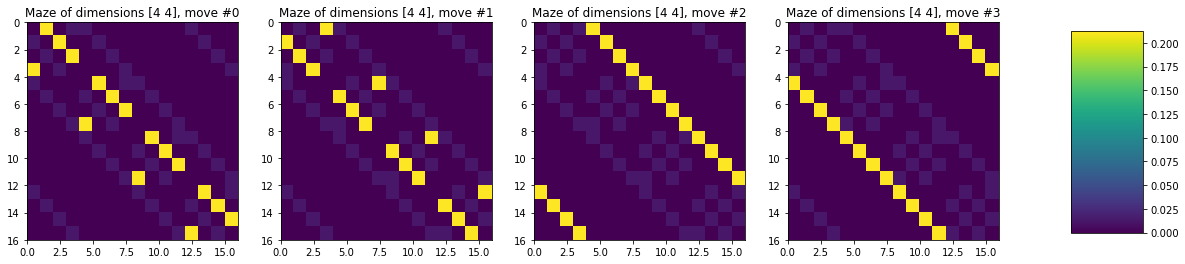

In [3]:
mz = Maze2D(size, walls=False,proba_opposite=0.05,proba_others=0.05)
environment = tf_py_environment.TFPyEnvironment(mz)

mz = environment.pyenv.envs[0]
mz.set_spike_train_params(t_steps, high_freq_p=1.0, low_freq_p=0.0)

t_mat = mz.build_transition_matrix(separate_actions=True)

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(t_mat):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move #{i}")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)
plt.show()

##### State-action transition matrix 

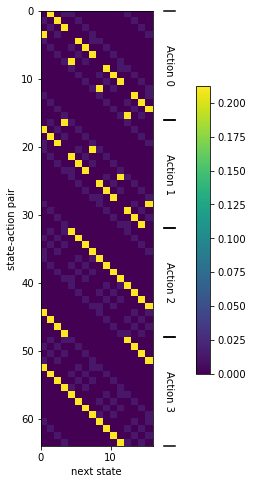

In [4]:
block_t_mat = tf.concat([(tf.constant(mat)) for mat in t_mat], axis=0)
f,ax = plt.subplots(1,1, figsize=(2,8))
im = mz.plot_t_mat(ax, block_t_mat)
for i in range(n_actions):
    annotate_yrange(16*i,16+16*i, f'Action {i}', offset=1.1, width=0.1, ax=ax, text_kwargs={'rotation':-90})
ax.set_xlabel('next state')
ax.set_ylabel('state-action pair')

cax = f.add_axes([1.2, 0.25, 0.1, 0.5])
f.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [5]:
n_obs = mz.tot_room_number
n_wm = mz.tot_room_number*n_actions
n_err = mz.tot_room_number*out_in_ratio

# logbase = "goodlogs/"
logbase = "logs/"

logdir = logbase + "RL_test" + f"thr-{theta}_" + f"eta1-{eta1:.3f}_" + f"eta2-{eta2:.3f}_"+ f"{n_obs}_{n_wm}+{n_err}/" + f"seed{seed}/" + datetime.now().strftime("%m%d-%H%M")
writer = tf.summary.create_file_writer(logdir)
logdir

'logs/RL_testthr-0.0_eta1-0.001_eta2-0.015_16_64+128/seed145/0609-1216'

### Weight initialization
The weight matrix combines both populations for ease of computation

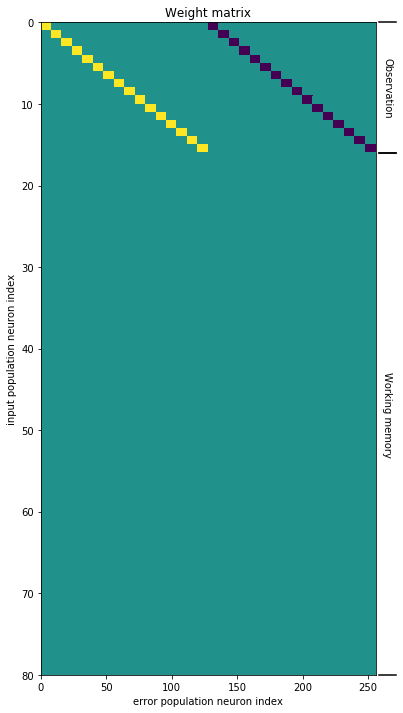

In [6]:
# Initialize network [two input sets of size n_in and two output populations of size n_err]

# Block identity matrix
obs_m1 = (1.0) * np.kron(np.eye(n_obs), np.ones([1, out_in_ratio]))  #martin put them to 1 too

# wm_m1 = rd.uniform(1.5, 2., (n_in, n_pop))
wm_m1 = np.zeros((n_wm, n_err))

full_w_in = np.block([[obs_m1, -obs_m1], [-wm_m1, wm_m1]])

f,ax = plt.subplots(1,1, figsize=(6,12))
mz.plot_t_mat(ax, full_w_in)
ax.set_title('Weight matrix')
ax.set_xlabel('error population neuron index')
ax.set_ylabel('input population neuron index')
annotate_yrange(0,16, f'Observation', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})
annotate_yrange(16,80, f'Working memory', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})

plt.show()

### Readouts initialization

In [7]:
action_shape = environment.action_spec().maximum + 1
value_shape = 1

time_step_spec = ts.time_step_spec(environment.observation_spec())
action_spec = environment.action_spec()
inp_shape = n_err * 2

class ActorLinearReadout(tf_network.Network):

    def __init__(self, inp_shape, output_shape):
        """ inp_shape is needed to specify the size of the input"""
        self.inp_shape = inp_shape
        input_state_spec = tf.TensorSpec(shape=(self.inp_shape), dtype=np.int32, name='one_hot_obs')

        super(ActorLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='random_normal',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        output = tf.cast(observations, tf.float32)
        
        for layer in self._sub_layers:
            output = layer(output)
        output = tf.nn.softmax(output)
        
        actions_categorical_dist = tfp.distributions.Categorical(probs=output, dtype=tf.int32)
        
        # Scale and shift actions to the correct range if necessary.
        return actions_categorical_dist, network_state
    
class CriticLinearReadout(tf_network.Network):

    def __init__(self, inp_shape, output_shape):
        """ inp_shape is needed to specify the size of the input"""
        self.inp_shape = inp_shape
        input_state_spec = tf.TensorSpec(shape=(self.inp_shape), dtype=np.int32, name='one_hot_obs')

        super(CriticLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='random_normal',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        output = tf.cast(observations, tf.float32)

        for layer in self._sub_layers:
            output = layer(output)
                
        return tf.squeeze(output, axis=-1), network_state

In [8]:
actor_net = ActorLinearReadout(inp_shape, action_shape)
value_net = CriticLinearReadout(inp_shape, value_shape)

actor_net.create_variables()
value_net.create_variables()

### Define discount matrix

In [9]:
# Pre compute triangular matrix of gamma powers, useful to compute future return
increasing_t_steps = tf.range(episode_lenght, dtype=tf.float32)
returns = (tf.ones(episode_lenght)*gamma)**increasing_t_steps
rolling=[]
for r in range(episode_lenght):
    rolling.append(tf.roll(returns, r, axis=0))
gamma_matrix = tf.linalg.band_part(tf.stack(rolling, axis=0), 0, -1)

In [10]:
gamma_matrix

<tf.Tensor: shape=(25, 25), dtype=float32, numpy=
array([[1.        , 0.9       , 0.80999994, 0.7289999 , 0.6560999 ,
        0.5904899 , 0.5314409 , 0.47829682, 0.43046713, 0.3874204 ,
        0.34867835, 0.3138105 , 0.28242946, 0.25418648, 0.22876784,
        0.20589104, 0.18530194, 0.16677174, 0.15009457, 0.1350851 ,
        0.12157659, 0.10941893, 0.09847704, 0.08862933, 0.07976639],
       [0.        , 1.        , 0.9       , 0.80999994, 0.7289999 ,
        0.6560999 , 0.5904899 , 0.5314409 , 0.47829682, 0.43046713,
        0.3874204 , 0.34867835, 0.3138105 , 0.28242946, 0.25418648,
        0.22876784, 0.20589104, 0.18530194, 0.16677174, 0.15009457,
        0.1350851 , 0.12157659, 0.10941893, 0.09847704, 0.08862933],
       [0.        , 0.        , 1.        , 0.9       , 0.80999994,
        0.7289999 , 0.6560999 , 0.5904899 , 0.5314409 , 0.47829682,
        0.43046713, 0.3874204 , 0.34867835, 0.3138105 , 0.28242946,
        0.25418648, 0.22876784, 0.20589104, 0.18530194, 0.166771

### Network initialization 

In [11]:
net = Lif3fLoop(n_obs=n_obs, n_wm=n_wm, n_err1=n_err, n_err2=n_err,
                w_in=full_w_in, eta1=eta1, eta2=eta2, theta=theta, seed=seed)

### Input preparation and reset environment

State: 	 11
Reward position: 10


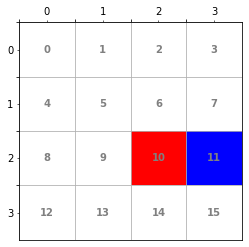

In [12]:
# Reset environment and creates first initial_time_step of trajectory
initial_time_step = environment.reset()
print(f"State: \t {initial_time_step.observation[0,0].numpy()}")
print(f"Reward position: {mz.reward_pos}")

fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, mz.maze_array)
mplot.color_square(ax, mz.get_coordinates(mz._state), 'b')
mplot.color_square(ax, mz.get_coordinates(mz.reward_pos), 'r')

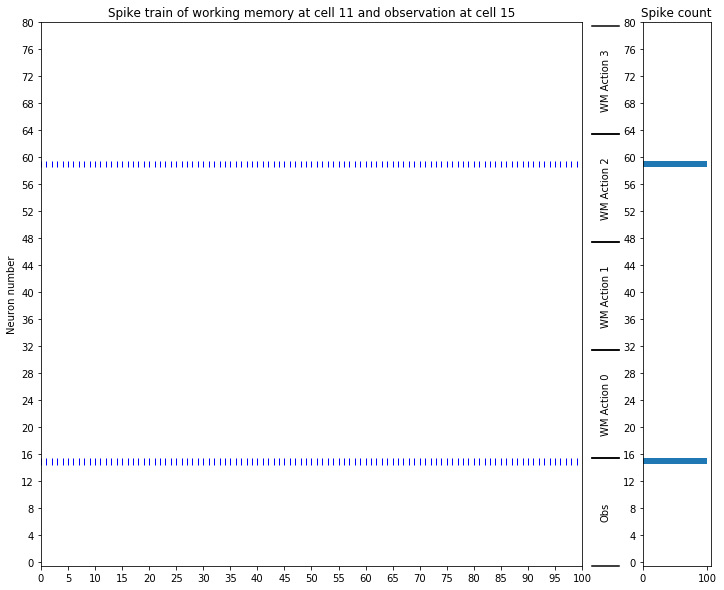

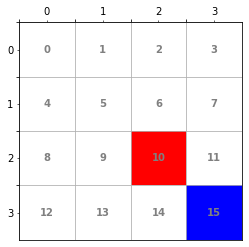

In [13]:
# create observation and working memory input spike trains and concatenate them together [1, t_steps, n_in * 2]
old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, action)))
spk_obs = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state)))

# When querying the network for nex possible states, observation is nulled
spk_obs_query = spk_obs*0.0

inputs = tf.concat([spk_obs, spk_wm], axis=-1)


f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, inputs, linewidth = 1, color='b')
ax.set_title(f'Spike train of working memory at cell {old_pos} and observation at cell {mz._state}')
ax.set_ylabel("Neuron number")

spk_count = tf.reduce_sum(inputs, axis=0)
ax2.barh(np.arange(n_obs+n_wm), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))
ax.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))

annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(4):
    annotate_yrange(15.5+i*mz.tot_room_number, 15.5+16+i*mz.tot_room_number, f'WM Action {i}',
                    offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, mz.maze_array)
mplot.color_square(ax, mz.get_coordinates(mz._state), 'b')
mplot.color_square(ax, mz.get_coordinates(mz.reward_pos), 'r')

plt.show()

### Simulation

In [14]:
a_trace = []
s_trace = []
f_trace = []
t_mat_trace = [t_mat]

rnn_inner_state = None

last_v = None
last_activity = None


@tf.function
def run_step(inp, v, a):
    return net.run(inp, v, a)

@tf.function 
def run_query(inp, v):
    return net.run_no_plasticity(inp, v)

In [15]:
@tf.function
def loss_fun(value_net, actor_net, observations, actions, rewards, gamma_matrix, optimizer):
    
    # to substitute with proper batching
    returns = tf.expand_dims(tf.linalg.matvec(gamma_matrix, rewards), 0)
    
    # Compute losses
    with tf.GradientTape() as tape:

        # critic loss
        v_estimates, _ = value_net(observations, (), ())
        critic_loss = tf.reduce_sum((v_estimates - returns)**2)

        # actor loss
        d, _ = actor_net(observations, (), ())
        gather_indices = tf.stack([tf.range(episode_lenght, dtype=tf.int32), actions], axis=1)

        log_pi = tf.math.log(tf.gather_nd(d.probs, gather_indices))

        actor_loss = tf.reduce_sum(log_pi*tf.stop_gradient(value_net(observations, (), ())[0] - returns))

        loss = critic_loss + actor_loss

        grads = tape.gradient(loss, actor_net.trainable_weights + value_net.trainable_weights)
        optimizer.apply_gradients(zip(grads, actor_net.trainable_weights + value_net.trainable_weights))

#### Example of query spike train

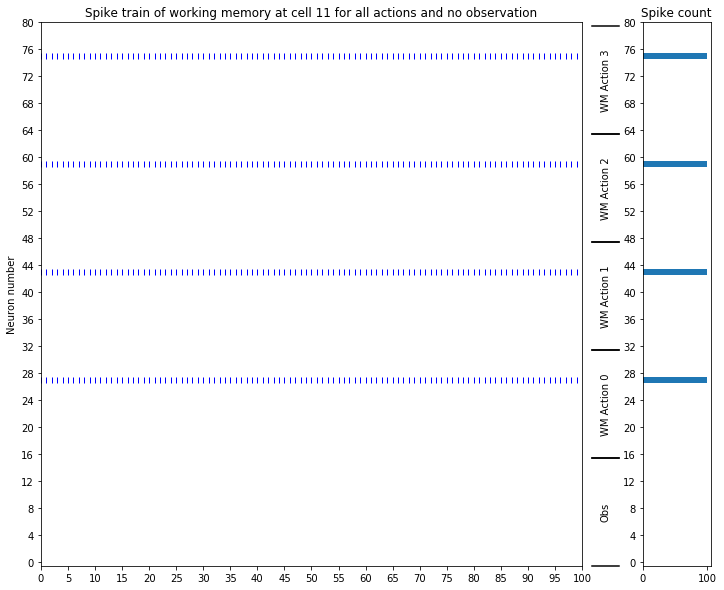

In [16]:
spk_wm_query = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, np.arange(n_actions))))
inputs = tf.concat([spk_obs_query, spk_wm_query], axis=-1)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, inputs, linewidth = 1, color='b')
ax.set_title(f'Spike train of working memory at cell {old_pos} for all actions and no observation')
ax.set_ylabel("Neuron number")

spk_count = tf.reduce_sum(inputs, axis=0)
ax2.barh(np.arange(n_obs+n_wm), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))
ax.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))

annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(4):
    annotate_yrange(15.5+i*mz.tot_room_number, 15.5+16+i*mz.tot_room_number, f'WM Action {i}',
                    offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})


In [17]:
trace = []

with trange(tot_episodes, desc='RL loop',leave=False) as t_rl:
    for e in t_rl:  # LOOP EPISODES
         
        observations = [tf.constant(mz._state)]
        actions = []
        rewards = []
                
        z_query_count = []
        
        with trange(episode_lenght, desc="SNN Loop", leave=False) as t_snn:
            for i in t_snn:
    
                ######### QUERY STEP #############

                spk_wm_query = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, np.arange(n_actions))))
                inputs = tf.concat([spk_obs_query, spk_wm_query], axis=-1)

                _, z_query = run_query(inputs, None)
                
                # append features from error population
                z_query_count.append(tf.reduce_sum(z_query, axis=0))
                
                ######### TAKE ACTION ############

                action = actor_net(tf.expand_dims(z_query_count[-1], axis=0), (), ())[0].sample()
                transition = environment._step(action)
                                
                observations.append(tf.squeeze(transition.observation))
                actions.append(action)
                rewards.append(transition.reward)
                
                ######### UPDATE SNN #############
                
                spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(observations[i], actions[i])))
                spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(observations[i+1]))
                inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)
                
                v, z, activity, surprise = run_step(inputs, None, None)
                
                ######### LOGS       #############
                
                a_trace.append(activity)
                s_trace.append(surprise)

                learned_t_mat = average_w_matrix(net.w_in*1.0, out_in_ratio)
                learned_t_mat = normalize(learned_t_mat[-n_wm:, -n_obs:], norm='l1', axis=0)

                f_trace.append(np.sum((block_t_mat-learned_t_mat)**2))

                with writer.as_default():
                    tf.summary.scalar('frobenius_norm_transition_error', f_trace[-1], step=e)
                    tf.summary.scalar('average_surprise', tf.reduce_mean(s_trace[-1]), step=e)
                    tf.summary.scalar('average_activity', tf.reduce_mean(a_trace[-1]) / net.A0, step=e)

                if i % 60 == 0:
                    with writer.as_default():
                        tf.summary.image('learnt_transition_matrix', draw_matrix_tb(learned_t_mat, figsize=(5,8)), step=e)
                    if i % 1500 == 0:
                        with writer.as_default():
                            tf.summary.image('true_transition_matrix', draw_matrix_tb(block_t_mat, figsize=(5,8)), step=e)
                                            
        ######### UPDATE RL  #############
        
        trace.append(tf.reduce_sum(rewards).numpy())
#         if trace[-1] == 0:
#             trace[-1] -= 1
            
        t_rl.set_postfix(tot_reward=tf.reduce_sum(rewards).numpy())    
        
        print(f"obs: {tf.stack(observations).numpy()}")
        print(f"act: {np.squeeze(tf.stack(actions).numpy())}")
        print(f"rew: {trace[-1]}")
        
        loss_fun(value_net, actor_net, tf.stack(z_query_count), 
                 tf.squeeze(tf.stack(actions)), tf.squeeze(tf.stack(rewards)),
                 gamma_matrix, optimizer)


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
obs: [15 14 10  4  0  1  2  6 10 14 15 12 13  9 13  1  2  1  2 14  2 14 15  3
  2 14]
act: [1 3 2 3 0 0 2 2 2 0 0 0 3 3 2 0 1 0 3 2 3 0 2 1 3]
rew: 2.0


obs: [14  2  6  5  9  8 12  0  4  8  4  8 11  7  6  2  1  0  3  2  1 13 12 15
 14 13]
act: [2 2 1 1 1 2 2 2 3 2 2 1 3 1 1 1 1 1 1 1 3 1 1 1 1]
rew: 0.0


obs: [13 12 15 14 13 12 15 14 13 14 13 12 15 14 13 12 15 14 13  1  0  3  2  6
  5  4]
act: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]
rew: 0.0


obs: [ 4  7 11 10 10  9  8 11 15 14 13 12  0  4  5  4  8 12 15 12 15  3  2  1
  0  3]
act: [1 2 1 1 1 1 1 1 1 1 1 0 2 1 1 2 1 1 1 1 2 1 1 1 1]
rew: 1.0


obs: [ 3  2  1  0  1  0  3  2  3  2  1  0  3  2  1  5  4  5  4  8 11 10  9 13
 12 15]
act: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 2 1 1]
rew: 1.0


obs: [15 12 15 14 13 12  0  4  0  4  0  3  2  1  2  1  0  3  2  1  0  3  2  1
  2  3]
act: [2 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [ 3  7  6  5  4  7  6  5  4  7  3  2  1  2  1  0 12 15 12 15 14 13 12 15
 14 13]
act: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
rew: 0.0


obs: [13  1  0  3  2  1  0  3  2  1  0  3  2  1  0  3  2  1 13 12 15 14 13 12
 15 14]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [14 15 14  2  1  0  3  2  6  5  4  5  9  8  9  8 11  8 11 10  6  5  6  5
  9 10]
act: [0 1 2 0 1 1 1 2 1 1 0 0 1 1 1 1 1 1 1 2 1 0 1 1 0]
rew: 2.0


obs: [10  4  7 11  8 11 10 10  9 10 15 14 13 12 15 14  2  6  5  4  0  3  2  1
  0  3]
act: [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1]
rew: 2.0


obs: [ 3  2  6  5  4  5  4  7  6  5  9  8 11 10  8 12 15  3  2  1  0  4  7  6
  5  9]
act: [1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2]
rew: 1.0


obs: [ 9  8  9  8 11  8 11  7  6  5  4  7  6  5  4  7  6  5  4  7  6  5  4  7
  3  2]
act: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [ 2  1  0  3  2  1  0  3  2  1  2  1  0 12 15 14 13 12 15 14 13 12 15 14
 13 12]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [12 15 14 13 12 15 14 13 12 15 14 13 12 15 14 13 12  0  3  2  1  0  3  2
  1  0]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [0 3 2 1 0 3 2 1 0 3 2 3 7 6 5 4 7 6 5 4 7 6 5 4 7 6]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [6 5 4 7 6 5 4 7 6 5 6 5 4 7 6 5 6 5 4 7 6 5 4 7 3 2]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [ 2  1  0  3  2  1  0 12 15 14 13 12 15 11 10 14 13 12 15 11 10  6  5  4
  5  1]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
rew: 2.0


obs: [ 1  0  3  2 14 13 12 15 14 13 12 15 14 10  7  6  5  4  0  3  2  1  5  4
  0  3]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 1.0


obs: [ 3  2  1  0  3  2  6  5  6  5  4  0  3  2  1  0  3  2  1  0  3 15 14 13
 12 15]
act: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [15 14 13 14 13 12 15 14 13 12 15 14 13 12 15 14 13  9  8 11 10  1  5  4
  7  3]
act: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
rew: 1.0


obs: [ 3  2  1  0  3  2  3  2  1  0 12 15 11 10  7 11 10  8 11 10  1  0  4  7
  6  5]
act: [1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1]
rew: 3.0


obs: [ 5  1  2  1  0  1  0  3  7  3  2  6  5  6  5  6  5  9  8 11 10 10 14 13
  1  0]
act: [3 0 1 1 0 1 1 2 1 1 3 1 0 1 2 1 2 1 1 1 1 2 1 2 1]
rew: 1.0


obs: [ 0  1 13 14 13 14 13 12 15 12 15 14 13  1  0  3  2 14  2  1  0  3  2  1
  0  3]
act: [0 1 0 1 0 1 1 1 0 1 1 1 2 1 1 1 3 2 1 1 1 1 1 1 1]
rew: 0.0


obs: [ 3  2  1  0  1  5  4  7  4  7  4  7  6  5  9  8 11 15 14 15 14 13 12 15
 14 13]
act: [1 1 1 0 2 1 1 0 1 0 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1]
rew: 0.0


obs: [13 12  0  3 15 14  2  1  5  4  7  6  5  9  8 12 15 14 10  2  1  0  3  2
  3  2]
act: [1 2 1 2 1 2 1 2 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1]
rew: 1.0


obs: [ 2  1  5  6  5  4  7  4  7 11 15  3  2  3  2  1  0  3  2 14 13 12 13 12
 15 11]
act: [1 2 2 1 1 1 0 1 2 2 2 1 1 2 1 1 1 1 1 1 0 0 3 1 3]
rew: 0.0


obs: [11 15  3  2  1  0  3  2  6  5  4  7  4  5  9  8 11 15  3  7 11 15  3  2
  1  0]
act: [2 1 1 1 1 1 1 2 2 1 1 2 0 2 1 1 2 2 2 1 2 2 1 1 1]
rew: 0.0


obs: [ 0  1  0  3  7  6  5  4  7  6  5  4  7 11 15  3  2  1  5  6  2  3  2  1
  5  4]
act: [2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 0 3 1 1 1 2 1]
rew: 0.0


obs: [ 4  7 11 10  8 11  8 11 10  6  5  4  7 11 10  1  5  9  8 11 10  5  4  7
  6  5]
act: [1 2 1 1 1 0 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1]
rew: 4.0


obs: [ 5  9  8  4  7  6  5  4  5  4  8  4  7  6 10 13 12  0  3  7  6  5  1  0
  3 15]
act: [2 1 1 1 1 1 1 0 2 2 3 1 1 2 1 1 2 1 2 1 1 1 1 1 1]
rew: 1.0


obs: [15  3  2  1  0  4  7  6  5  4  7  6  5  4  8 11 10 14 13 12 15 14  2  1
  5  9]
act: [2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 2 2]
rew: 1.0


obs: [ 9  8 12 15 14 13  1  5  4  7  6  7 11 10 10 14  2  1  0  4  7 11 15  3
  7  6]
act: [1 2 1 1 1 2 2 1 1 1 0 2 1 1 2 2 1 1 2 1 2 1 2 2 1]
rew: 1.0


KeyboardInterrupt: 

In [ ]:
tf.stack(observations).numpy(), tf.squeeze(tf.stack(actions))

<BarContainer object of 128 artists>

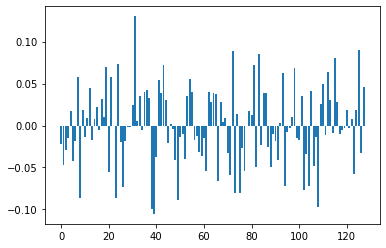

In [29]:
plt.bar(np.arange(128),value_net.trainable_weights[0][-128:,0].numpy())

In [21]:
for i, v in enumerate(value_net.trainable_weights[0][-128:].numpy()):
    print(f"state {np.floor_divide(i,8)}, v={v}")

state 0, v=[-0.02237415]
state 0, v=[-0.04650148]
state 0, v=[-0.02914947]
state 0, v=[-0.01524993]
state 0, v=[0.01728412]
state 0, v=[-0.04229407]
state 0, v=[-0.01881606]
state 0, v=[0.05836713]
state 1, v=[-0.08580344]
state 1, v=[0.01867757]
state 1, v=[-0.01336163]
state 1, v=[0.00949305]
state 1, v=[0.04434966]
state 1, v=[-0.01716524]
state 1, v=[0.00821277]
state 1, v=[0.02170398]
state 2, v=[-0.00544791]
state 2, v=[0.03189116]
state 2, v=[0.00976599]
state 2, v=[0.06970549]
state 2, v=[-0.05562251]
state 2, v=[0.05807902]
state 2, v=[-0.00055018]
state 2, v=[-0.08619239]
state 3, v=[0.07367171]
state 3, v=[-0.01992597]
state 3, v=[-0.07309615]
state 3, v=[-0.01834518]
state 3, v=[-0.0015779]
state 3, v=[-0.00121961]
state 3, v=[0.02460753]
state 3, v=[0.1302162]
state 4, v=[0.00531249]
state 4, v=[0.03485618]
state 4, v=[-0.00506249]
state 4, v=[0.03943412]
state 4, v=[0.04178974]
state 4, v=[0.03222896]
state 4, v=[-0.09900826]
state 4, v=[-0.10530765]
state 5, v=[-0.037773

In [ ]:
actor_net.trainable_weights[0][-128:].numpy()

In [ ]:
np.argmax(actor_net.trainable_weights[0][-128:].numpy(), axis=1)

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,9))
ax1.plot(tf.reduce_mean(s_trace, axis=1))
ax1.set_title('average surprise per epoch')

ax2.plot(np.array(tf.reduce_mean(tf.stack(a_trace), axis=1) / net.A0))
ax2.set_title('population activity')
# ax2.hlines(theta, 0, epochs, 'r','--', zorder=3)

ax3.plot(np.array(f_trace))
ax3.set_title('frobenius norm of transition matrix error')
plt.show()


We see a very different activity profie with respect to either the fully deterministic case of state-action or the fully stochastic case of exploration. This is due to the nature of the network to increase its activity when seeing unexpected events such as low probability stochastic actions. More in details explanation below

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n = 100

_, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,15))

a = np.array(tf.reduce_mean(tf.stack(a_trace), axis=1) / net.A0)
roll_mean = pd.Series(a).rolling(window=n).mean().iloc[n-1:].values
roll_up = pd.Series(a).rolling(window=n).quantile(0.75).iloc[n-1:].values
roll_down = pd.Series(a).rolling(window=n).quantile(0.25).iloc[n-1:].values

ax1.plot(roll_mean)
ax1.fill_between(np.arange(roll_mean.shape[0]), roll_up, roll_down,facecolor='blue', alpha=0.25)
ax1.set_title(f'filtered population activity (n={n})')
# ax1.hlines(tf.reduce_mean(tf.stack(a_trace), axis=(0,1)) / net.A0, 0, epochs, 'r','--', zorder=3)

ax2.plot(a)
ax2.set_title('population activity')
ax1.set_ylim(ax2.get_ylim())

# ax3.plot(np.arange(18000,18250), a[18000:18250])
# ax3.set_title('zoom on population activity')
# ax3.set_ylim(ax2.get_ylim())


ax4.hist(a, bins=500)
ax4.set_title('distribution of activity values')
ax4.set_xlabel('population activity level')
pop_levels = np.arange(0.2,0.7, 0.001)
cum_dist = np.array([np.sum(a>x)/a.shape[0] for x in pop_levels])
point085 = pop_levels[np.argmin(np.abs(cum_dist-0.15))]
ax4.vlines(point085, ax4.get_ylim()[0], ax4.get_ylim()[1], 'r','--', zorder=3)
ax4.vlines(theta, ax4.get_ylim()[0], ax4.get_ylim()[1], 'g','--', zorder=3)
ax4.text(point085*1.01, ax4.get_ylim()[1]*0.9, "85th percentile", color='r')
ax4.text(theta*1.01, ax4.get_ylim()[1]*0.8, "theta", color='g')
plt.show()

The population activity in a case with slightly stochastic actions (15% probability of choosing a random action) has a much higher variability, do we need to higher the threshold to account for this variability? Is the threshold on the activity a threshold set to define what is expected uncertainty and unexpected uncertainty?

Because with threshold theta left around 0.31 the network will be always surprised whenever a stochastic action occurs.

## Simulate step by step and view of error population

- We can see that error population 1 (which receives excitation from the observation population and inhibition from the working memory) correctly reflect the signal of the observation. Note that when the observation state is not the one the action was predicting, the activity of the error population 1 is much higher (around 20 spikes instead of 10, still at the observed state)

- Error population 2 instead is activated in the three other states the transition could occur (accounting for the slight stochasticity of the action). Note that when a stochastic transition occurs, the supposed next state dictated from the action fires a lot since it is not inhibited (around 20 spikes instead of 0)

#### Query phase

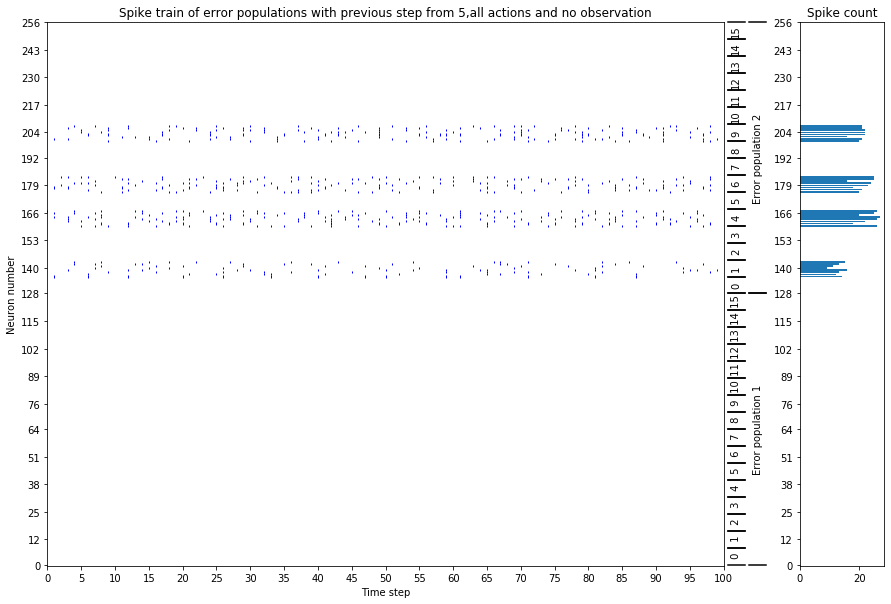

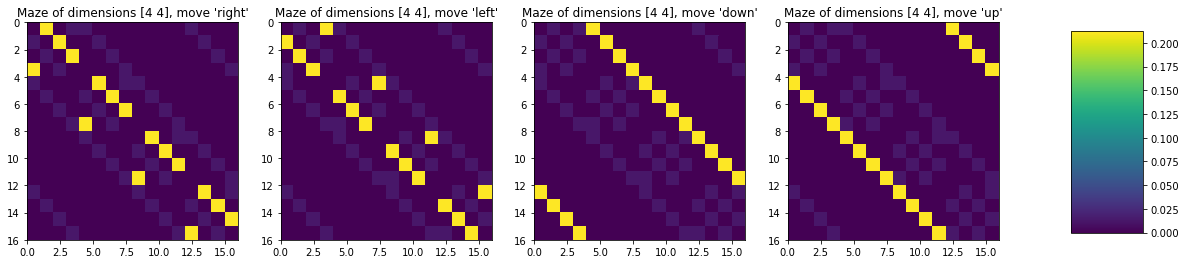

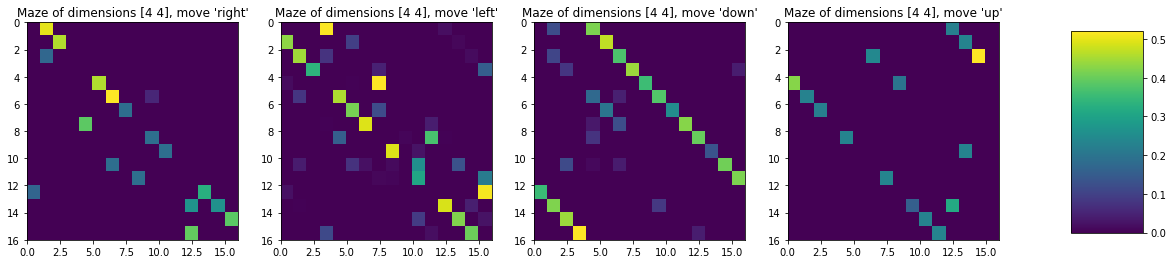

In [30]:
old_pos = 5

spk_wm_query = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, np.arange(n_actions))))
inputs = tf.concat([spk_obs_query, spk_wm_query], axis=-1)

_, z_query = run_query(inputs, None)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, z_query, linewidth = 1, color='b')
ax.set_title(f"Spike train of error populations with previous step from {old_pos},\
all actions and no observation")
ax.set_ylabel("Neuron number")
ax.set_xlabel("Time step")

spk_count = tf.reduce_sum(z_query, axis=0)
ax2.barh(np.arange(z_query.shape[1]), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, z_query.shape[1], 21)))
ax.set_yticks(np.floor(np.linspace(0, z_query.shape[1], 21)))

# annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(mz.tot_room_number):
    annotate_yrange(i*out_in_ratio, (i+1)*out_in_ratio, f' {i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})
    annotate_yrange((i+mz.tot_room_number)*out_in_ratio, (i+1+mz.tot_room_number)*out_in_ratio, f'{i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})

annotate_yrange(0, mz.tot_room_number*out_in_ratio, f'Error population 1',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})
annotate_yrange(mz.tot_room_number*out_in_ratio, 2*mz.tot_room_number*out_in_ratio, f'Error population 2',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})

# Plot transitions to help understand the actions

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(t_mat_trace[-1]):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)


fig, ax = plt.subplots(1, 4, figsize=(20, 4))

learned_t_mat = average_w_matrix(net.w_in*1.0, out_in_ratio).numpy()

for i,mat in enumerate(learned_t_mat[-n_wm:, -n_obs:].reshape(n_actions, mz.tot_room_number, mz.tot_room_number)):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)

plt.show()


#### Action selection phase

In [ ]:
actor_net(tf.expand_dims(spk_count, axis=0), (), ())[0].sample()

In [ ]:
for x in actor_net.trainable_weights[0].numpy():
    print(x)

#### Observation phase

In [ ]:
old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, action)))
spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state))
inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)

v, z, activity, surprise = run_step(inputs, last_v, last_activity)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, z, linewidth = 1, color='b')
ax.set_title(f"Spike train of error populations with previous step from {old_pos},\
action '{act_str[action]}' and observation at {new_pos}. Activity: {np.mean(activity/net.A0):.2f}")
ax.set_ylabel("Neuron number")
ax.set_xlabel("Time step")

spk_count = tf.reduce_sum(z, axis=0)
ax2.barh(np.arange(z.shape[1]), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))
ax.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))

# annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(mz.tot_room_number):
    annotate_yrange(i*out_in_ratio, (i+1)*out_in_ratio, f' {i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})
    annotate_yrange((i+mz.tot_room_number)*out_in_ratio, (i+1+mz.tot_room_number)*out_in_ratio, f'{i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})

annotate_yrange(0, mz.tot_room_number*out_in_ratio, f'Error population 1',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})
annotate_yrange(mz.tot_room_number*out_in_ratio, 2*mz.tot_room_number*out_in_ratio, f'Error population 2',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})

# Plot transitions to help understand the actions

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(t_mat_trace[-1]):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)


fig, ax = plt.subplots(1, 4, figsize=(20, 4))

learned_t_mat = average_w_matrix(net.w_in*1.0, out_in_ratio).numpy()

for i,mat in enumerate(learned_t_mat[-n_wm:, -n_obs:].reshape(n_actions, mz.tot_room_number, mz.tot_room_number)):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)


plt.show()


## Final weight matrix

In [ ]:
f,ax = plt.subplots(1,1, figsize=(6,12))
mz.plot_t_mat(ax, net.w_in.numpy())
ax.set_title('Weight matrix')
ax.set_xlabel('error population neuron index')
ax.set_ylabel('input population neuron index')
annotate_yrange(0,16, f'Observation', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})
annotate_yrange(16,80, f'Working memory', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})

plt.show()

In [ ]:
environment._step(2)